# Датасет по данным чятика

### Немного упоролся и решил поизучать чего понапописал народ в чатике devkz

Чтобы вытащить данные буду использовать библиотеку **telethon**

Для начала авторизуемся

In [49]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from telethon import TelegramClient

import pandas as pd
import numpy as np

import re

from collections import Counter
import time

api_id = 149628
api_hash = '2cf6a449f6ce8c93589bfa19ac6be9c9'
phone_number = '+77025899060'

client = TelegramClient('session_id', api_id=api_id, api_hash=api_hash)

assert client.connect()

if not client.is_user_authorized():
    client.send_code_request(phone_number)
    me = client.sign_in(phone_number, input('Enter code: '))
    print(me.stringify())
    
chat_id = -1001075169847

In [35]:
def load_batch(chat_id, batch_size, last_batch_message_id):
    return client.get_message_history(chat_id, limit=batch_size, offset_id=last_batch_message_id)

def process_batch(batch):
    processed_messages = []
    for current_message in batch:
        try:
            current_message.media
            processed_messages.append(current_message)
        except:
            pass
    return processed_messages

In [47]:
max_messages = 1000000000

work_messages = []
time_elapsed = 0
batch_size = 10000
last_batch_message_id = -1

try:    
    while(len(work_messages) < max_messages):
        try:
            time_batch_start = time.time()
            loaded_messages = load_batch(
                chat_id, batch_size, last_batch_message_id)
            processed_messages = process_batch(loaded_messages)
            if len(processed_messages)==0:
                break
            work_messages.extend(processed_messages)
            last_batch_message_id = processed_messages[-1].id
            batch_duration = time.time() - time_batch_start
            time_elapsed += batch_duration
            print('Batch with {0} messages loaded for {1} seconds'.format(
                len(processed_messages), int(batch_duration)
            ))
            print('History loaded until {}'.format(work_messages[-1].date))
            print('Overall loaded {0} messages for {1} minutes\n'.format(
                len(work_messages), int(time_elapsed / 60)
            ))
        except RuntimeError:
            print('RUNTIME ERROR - try load batch again')
        
except KeyboardInterrupt:
    pass

Batch with 9941 messages loaded for 168 seconds
History loaded until 2017-11-02 16:09:22
Overall loaded 59742 messages for 18 minutes

Batch with 9942 messages loaded for 166 seconds
History loaded until 2017-10-22 19:51:18
Overall loaded 69684 messages for 21 minutes

Batch with 9972 messages loaded for 161 seconds
History loaded until 2017-10-11 16:04:21
Overall loaded 79656 messages for 23 minutes

Batch with 9964 messages loaded for 169 seconds
History loaded until 2017-09-28 11:56:40
Overall loaded 89620 messages for 26 minutes

Batch with 9954 messages loaded for 154 seconds
History loaded until 2017-09-11 15:05:12
Overall loaded 99574 messages for 29 minutes

Batch with 9933 messages loaded for 158 seconds
History loaded until 2017-08-27 16:50:08
Overall loaded 109507 messages for 31 minutes

Batch with 9985 messages loaded for 155 seconds
History loaded until 2017-08-18 06:10:31
Overall loaded 119492 messages for 34 minutes

Batch with 9978 messages loaded for 161 seconds
Histo

IndexError: list index out of range

### Построил собственно датасет из самого необходимого

Также удалил всякую пунктуацию и построил себе айдишку пользователя из имени, фамилии, логина

In [50]:
corpus = pd.DataFrame(data = {
    'text': [mes.message for mes in work_messages],
    'is_media': [not mes.media == None for mes in work_messages],
    'is_bot': [mes.sender.bot for mes in work_messages],
    'writer_id': [mes.from_id for mes in work_messages],
    'username': [mes.sender.username for mes in work_messages],
    'first_name': [mes.sender.first_name for mes in work_messages],
    'last_name': [mes.sender.last_name for mes in work_messages],
    'mes_date': [mes.date for mes in work_messages],
    
})
corpus = corpus[~corpus.is_bot]
corpus = corpus[['mes_date', 'text', 'is_media', 'username', 'writer_id', 'first_name', 'last_name']]
corpus.text = corpus.text.fillna('').astype(str)

def remove_links_and_quotes(text):
    return ' '.join([word for word in text.split() if 'http' not in word and '@' not in word])
corpus.text = corpus.text.apply(lambda x: remove_links_and_quotes(x))

corpus = corpus[corpus.text.apply(lambda x: len(x) > 0)]
corpus.text = corpus.text.apply(lambda x: ' '.join(re.split('\W+', x.lower())))
corpus.sort_values('mes_date', inplace=True, ascending=True)

corpus.fillna('', inplace=True)
corpus['chatname'] = corpus['last_name'] + '_' + corpus['first_name'] + '(' + corpus['username'] + ')'

corpus.to_csv('devkz_chat.csv', index=None)

corpus.head(10)

,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
211277,2017-01-09 11:47:49,первый нах,False,LEXASOFT,6485625,LEXASOFT,,_LEXASOFT(LEXASOFT)
211276,2017-01-09 11:48:11,велкам,False,hinex,64005178,Roman,Hinex,Hinex_Roman(hinex)
211275,2017-01-09 11:58:03,говорят тут печеньки раздают,False,Arrim_kz,3481053,🎄Arrim🎄,,_🎄Arrim🎄(Arrim_kz)
211274,2017-01-09 12:12:44,шаломушки,False,,303712831,Фёдор,Дорофеев,Дорофеев_Фёдор()
211273,2017-01-09 12:13:05,саламчик,False,emilkip,77596906,Emil,Kip,Kip_Emil(emilkip)
211272,2017-01-09 12:13:25,алейкум,False,armanbest,103798332,Arman,Zhakupov,Zhakupov_Arman(armanbest)
211271,2017-01-09 12:13:47,где печеньки,False,armanbest,103798332,Arman,Zhakupov,Zhakupov_Arman(armanbest)
211270,2017-01-09 12:22:16,привет всем я паша ruby разработчик из алматы ...,False,rubyist,57210707,Pavel,Tkachenko,Tkachenko_Pavel(rubyist)
211269,2017-01-09 12:59:31,здаров,False,emilkip,77596906,Emil,Kip,Kip_Emil(emilkip)
211268,2017-01-09 13:08:21,печеньки в общении и обмене опытом вообще цель...,False,emilkip,77596906,Emil,Kip,Kip_Emil(emilkip)


In [48]:
corpus = pd.read_csv('devkz.csv')
corpus.fillna('', inplace=True)
corpus.mes_date = pd.to_datetime(corpus.mes_date)
corpus.head()

,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
0,2017-10-08 11:39:58,ануар можно мне сразу админство плс,False,,172015031,Yeldos,Balgabekov,Balgabekov_Yeldos()
1,2017-10-08 11:45:25,крч всем привет создал конфу в телеграмме для ...,False,cSneddy,212657982,Пельмешка,Sneddy,Sneddy_Пельмешка(cSneddy)
2,2017-10-08 12:17:14,запинь,False,hoogleraar,108539635,Дархан,,_Дархан(hoogleraar)
3,2017-10-08 12:52:51,всем привет,False,,50045174,Renat,Alimbekov,Alimbekov_Renat()
4,2017-10-08 13:01:34,,True,adilkhash,151436083,Adil,,_Adil(adilkhash)


In [51]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

def tokenize_me(file_text):
    #firstly let's apply nltk tokenization
    tokens = nltk.word_tokenize(file_text)

    #deleting stop_words
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    stop_words.extend(stopwords.words('english'))
    tokens = [i for i in tokens if ( i not in stop_words )]
    
    #cleaning words
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]

    return ' '.join(tokens)

corpus.text = corpus.text.apply(lambda x: tokenize_me(x))

corpus.to_csv('devkz_chat_tokens.csv', index=None)
corpus.head(10)

[nltk_data] Downloading package punkt to /home/sneddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sneddy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
211277,2017-01-09 11:47:49,первый нах,False,LEXASOFT,6485625,LEXASOFT,,_LEXASOFT(LEXASOFT)
211276,2017-01-09 11:48:11,велкам,False,hinex,64005178,Roman,Hinex,Hinex_Roman(hinex)
211275,2017-01-09 11:58:03,говорят печеньки раздают,False,Arrim_kz,3481053,🎄Arrim🎄,,_🎄Arrim🎄(Arrim_kz)
211274,2017-01-09 12:12:44,шаломушки,False,,303712831,Фёдор,Дорофеев,Дорофеев_Фёдор()
211273,2017-01-09 12:13:05,саламчик,False,emilkip,77596906,Emil,Kip,Kip_Emil(emilkip)
211272,2017-01-09 12:13:25,алейкум,False,armanbest,103798332,Arman,Zhakupov,Zhakupov_Arman(armanbest)
211271,2017-01-09 12:13:47,печеньки,False,armanbest,103798332,Arman,Zhakupov,Zhakupov_Arman(armanbest)
211270,2017-01-09 12:22:16,привет всем паша ruby разработчик алматы люблю...,False,rubyist,57210707,Pavel,Tkachenko,Tkachenko_Pavel(rubyist)
211269,2017-01-09 12:59:31,здаров,False,emilkip,77596906,Emil,Kip,Kip_Emil(emilkip)
211268,2017-01-09 13:08:21,печеньки общении обмене опытом вообще целью со...,False,emilkip,77596906,Emil,Kip,Kip_Emil(emilkip)


### Посмотрим, кто понапописал больше всех сообщений и наоставлял всяких стикеров

In [53]:
corpus.groupby('chatname')['text'].count().sort_values(ascending=False).head(15)

chatname
_Alexandr(shadowsmind)          31234
Izbassar_Tolegen(izbassar_t)    21318
_()                             14089
Zh_Airat(codev0)                12544
Akhmetkhan_Olzhas(mi7ter)       12427
Viktorson_Dmitriy(pengovan)     12111
Tkachenko_Pavel(rubyist)         8868
Noskov_Igor(igor_na)             7564
_SSH()                           6935
_resurtm(resurtm)                5910
RAKHMETOV_Serik(rakhmetov)       5202
Bayev_Nikita(drugoi)             4756
Ryskulova_Zhama(zhaaaaama)       4697
_Roka(rokakz)                    3367
Amantay_Eldar(steppefox)         3215
Name: text, dtype: int64

In [54]:
corpus.groupby('chatname')['is_media'].sum().sort_values(ascending=False).astype(int).head(15)

chatname
_Alexandr(shadowsmind)          321
Viktorson_Dmitriy(pengovan)     265
Zh_Airat(codev0)                231
Noskov_Igor(igor_na)            161
_()                              76
Bayev_Nikita(drugoi)             74
Akhmetkhan_Olzhas(mi7ter)        53
Tkachenko_Pavel(rubyist)         46
_resurtm(resurtm)                35
Сабыргалиев_Таир(tairs)          34
_SSH()                           23
_Leo(leotrubach)                 21
Amantay_Eldar(steppefox)         19
Izbassar_Tolegen(izbassar_t)     18
Смирнов_Сергей(SmS_SysteM)       17
Name: is_media, dtype: int64

### Посмотрим на активность чатика по дням

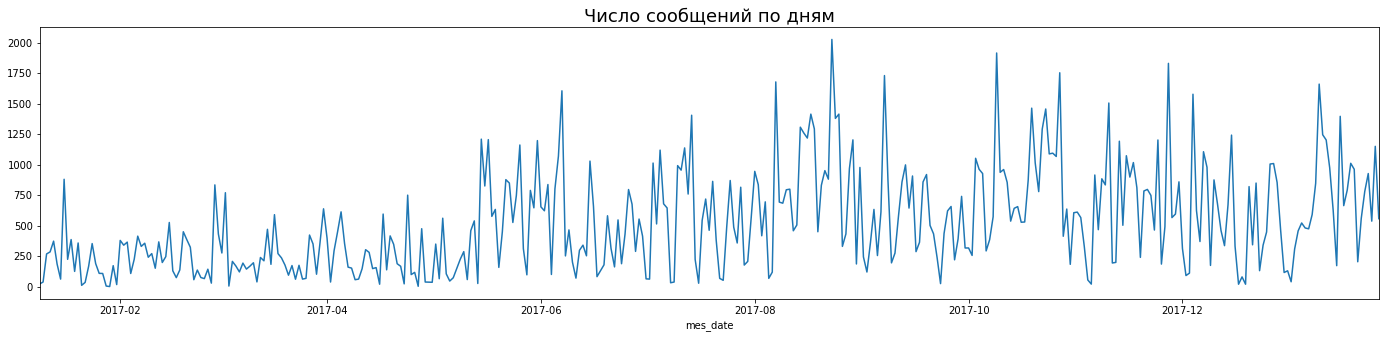

In [56]:
import matplotlib.pylab as plt
%matplotlib inline

corpus.groupby(corpus.mes_date.dt.date).count().mes_date.plot(figsize=(24,5))
plt.title('Число сообщений по дням', fontsize=18)
plt.savefig('devkz_bydays.png')

### И по времени: как видим максимум неплохо коррелирует с рабочим днем:)

Пришел на работу - открыл чатик. Все правильно сделал!

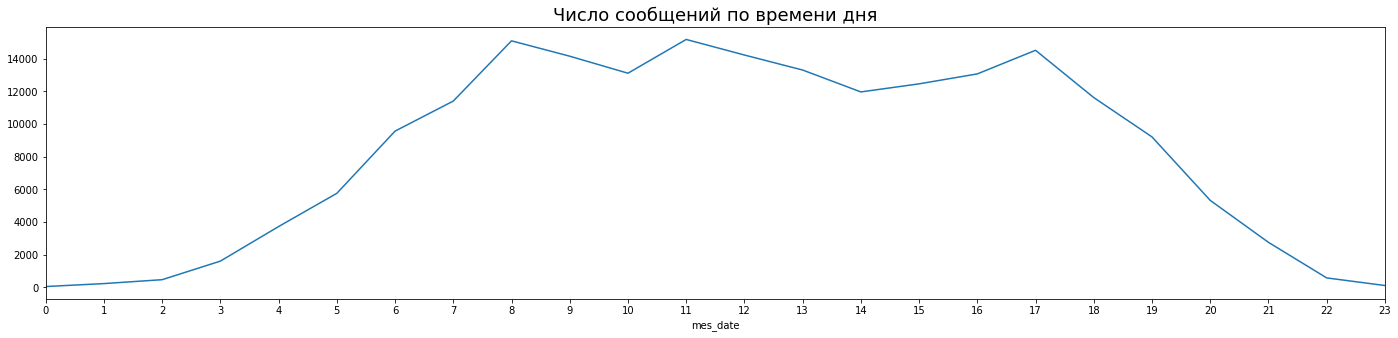

In [57]:
import matplotlib.pylab as plt
%matplotlib inline

corpus.groupby(corpus.mes_date.dt.hour).count().mes_date.plot(figsize=(24,5))
plt.title('Число сообщений по времени дня', fontsize=18)
plt.xticks(range(24))
plt.show()

# Тематическая модель по пользователям

### Фильтрация по частям речи

In [58]:
import pymorphy2

users_text = corpus[corpus.chatname.map((corpus.groupby('chatname')['text'].count() > 50))]

users_text = users_text.groupby('chatname').agg(lambda x: ' '.join(x))['text']

morph = pymorphy2.MorphAnalyzer()

In [59]:
# Apro
def normalise_string(input_str):
    bad_words = {'че','чет','её','ещё','такой','который','какой','очень',}
    norm_words_list = []
    for word in input_str.split():
        if not word.isdigit() and word not in bad_words:
            parsed = morph.parse(word)[0]
            if parsed.tag.POS not in {'NUMR', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}:
                norm_words_list.append(parsed.normal_form)
    return ' '.join(norm_words_list)

%time users_text_norm = users_text.apply(lambda x: normalise_string(x))
users_text_norm.head()

CPU times: user 2min 46s, sys: 96 ms, total: 2min 46s
Wall time: 2min 46s


chatname
A_Ержан(Astdev)                  спс вакансия скидывать кома обратиться помогат...
Adiyatov_Olzhas(redkuber)        hey olzhas github io robotics engineer кустана...
Ai_Askar(AskarAi)                никита красулин известный специалист мастер кл...
Akhmetkhan_Olzhas(mi7ter)        form name myform novalidate форма добавить пар...
Alpenov_Tanat(researcher2286)    весь привет работать удалённый россия интересо...
Name: text, dtype: object

In [60]:
def filter_string(input_str):
    bad_words = {'че','чет','её','ещё','такой','который','какой','очень',}
    norm_words_list = []
    for word in input_str.split():
        if not word.isdigit() and word not in bad_words:
            parsed = morph.parse(word)[0]
            if parsed.tag.POS not in {'NUMR', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}:
                norm_words_list.append(word)
    return ' '.join(norm_words_list)

%time users_text_filter = users_text.apply(lambda x: filter_string(x))
users_text_filter.head()

CPU times: user 2min 35s, sys: 100 ms, total: 2min 36s
Wall time: 2min 36s


chatname
A_Ержан(Astdev)                  спс вакансию скидывай кому обратиться помогать...
Adiyatov_Olzhas(redkuber)        hey olzhas github io robotics engineer кустана...
Ai_Askar(AskarAi)                никита красулин известный специалист мастер кл...
Akhmetkhan_Olzhas(mi7ter)        form name myform novalidate форме добавить пар...
Alpenov_Tanat(researcher2286)    всем привет работает удаленно россией интересу...
Name: text, dtype: object

### Выбор пороговых значений векторизации

Чтобы как-то выкинуть совсем уж редкие слова(аля очепятки) и совсем общеупортребительные слова

In [61]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time

def get_words_by_threshold_report(text_series, min_df=0.02, max_df=0.75):
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)

    counts = vectorizer.fit_transform(text_series)
    corpus_id2word = {value: key for key, value in vectorizer.vocabulary_.items()}

    print('Слов в словаре: {}\n'.format(counts.shape[1]))
    print('Слова до пороговой фильтрации: ', Counter(' '.join(text_series.values).split()).most_common(20), '\n')

    print('Слова у верхней границы:', [corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[-40:][::-1]])
    print()
    print('Слова у нижней границы: ', [corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[:20]])
    return counts, vectorizer, corpus_id2word

def get_lda_model(counts, corpus_id2word, num_topics=10, alpha_value=0.1, var_iter=50, passes=50):
    gensim_corpus = gensim.matutils.Scipy2Corpus(counts)
    t_start = time.time()
    lda = gensim.models.LdaModel(
        corpus=gensim_corpus,
        passes=passes,
        num_topics=num_topics,
        alpha=[alpha_value] * num_topics,
        iterations=var_iter,
        id2word=corpus_id2word,
        eval_every=0,
        random_state=42
    )
    current_score = lda.bound(gensim_corpus)
    time_ellapsed = int(time.time() - t_start)

    print('ELBO = {1:.4f}, time: {2} seconds'.format(
        alpha_value, current_score, time_ellapsed))
    
    gamma, _ = lda.inference(gensim_corpus)
    gamma = gamma / gamma.sum(1).reshape(-1, 1)
    
    return lda, gamma

def build_topic_words_report(lda, top_words_num=25, topic_names=None):
    if topic_names==None:
        topic_names = [''] * lda.num_topics
    topic_space = max(map(len, topic_names)) + 2
    
    if topic_space==2:
        for topic_index in range(lda.num_topics):
            print('{0} topic: {1}'.format(
                topic_index, ', '.join(list(zip(*lda.show_topic(topic_index, topn=top_words_num)))[0])))
        return
    
    for topic_index in range(lda.num_topics):
        print('{0} topic :{1: ^{2}}: {3}'.format(
            topic_index, topic_names[topic_index], topic_space,
            ', '.join(list(zip(*lda.show_topic(topic_index, topn=top_words_num)))[0])))
        
def build_topic_subjects_report(lda, gamma, text_series, topic_names=None):
    if topic_names==None:
        topic_names = [''] * lda.num_topics
    for topic_index in range(lda.num_topics):
        print('Topic {0} - {1}'.format(topic_index, topic_names[topic_index]))
        best_doc_indexes = gamma[:, topic_index].argsort()[-10:][::-1]
        
        subjects_with_proba = []
        for person_count, doc in enumerate(best_doc_indexes):
            if gamma[doc, topic_index] > 0.01 or person_count<3:
                subjects_with_proba.append('{0} - {1:.1%}'.format(text_series.index[doc], gamma[doc, topic_index]))
        print(', '.join(subjects_with_proba), '\n')


In [66]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_norm, min_df=0.02, max_df=0.75)

Слов в словаре: 18490

Слова до пороговой фильтрации:  [('такой', 5898), ('писать', 3883), ('вообще', 3837), ('человек', 3823), ('весь', 3359), ('работать', 3357), ('год', 3348), ('быть', 3344), ('делать', 3308), ('один', 3306), ('свой', 3152), ('мочь', 3152), ('думать', 2920), ('хотеть', 2829), ('который', 2669), ('самый', 2663), ('норма', 2555), ('говорить', 2466), ('какой', 2455), ('знать', 2428)] 

Слова у верхней границы: ['норма', 'проект', 'код', 'тип', 'язык', 'нормальный', 'хз', 'проблема', 'том', 'твой', 'жить', 'стать', 'пока', 'должный', 'кз', 'простой', 'сразу', 'всякий', 'идти', 'жизнь', 'чат', 'взять', 'деньга', 'сидеть', 'хуйня', 'java', 'брать', 'начать', 'пхп', 'тема', 'понимать', 'наш', 'лола', 'скал', 'мой', 'общий', 'задача', 'js', 'говно', 'друг']

Слова у нижней границы:  ['монарх', 'душевая', 'духовно', 'угольный', 'specify', 'почкование', 'split', 'поэтапно', 'дунуть', 'дудосить', 'уговаривать', 'пра', 'srp', 'углубиться', 'угарать', 'угарай', 'дуэль', 'дцп', '

In [67]:
lda_norm, gamma_norm = get_lda_model(counts, corpus_id2word, num_topics=10)

ELBO = -5375369.4413, time: 118 seconds


In [68]:
build_topic_words_report(lda_norm, top_words_num=20)

0 topic: норма, нормальный, жить, деньга, тип, js, ребёнок, проблема, страна, наш, друг, пока, php, сидеть, алматы, казахстан, месяц, купить, город, дом
1 topic: том, норма, язык, жи, проект, всякий, код, scala, типо, далее, жизнь, чувак, скал, хз, стать, дух, жаба, нормальный, кз, простой
2 topic: том, норма, проект, рубить, тест, пока, ща, месяц, далее, проблема, наверное, код, ruby, использовать, должный, взять, брать, идти, тенг, простой
3 topic: код, сразу, проект, нормальный, хз, брать, учить, чо, всякий, месяц, норма, тема, пока, жизнь, деньга, компания, платить, апи, несколько, должный
4 topic: религия, задача, язык, плата, принцип, том, иметь, понимать, срач, поэтому, интересный, твой, жизнь, нормальный, скрипт, смысл, идти, лола, ситуация, чувак
5 topic: пхп, нормальный, норма, сидеть, хз, стать, хуйня, щас, проект, жить, пыхер, php, пойти, js, твой, сразу, деньга, говно, идти, тип
6 topic: тип, проект, задача, java, кз, должный, язык, код, норма, хуйня, проблема, общий, брат

In [69]:
build_topic_subjects_report(lda_norm, gamma_norm, users_text_norm)

Topic 0 - 
_Aleksej(OldRetard) - 100.0%, Kaliyev_Rustem(kaliyev) - 99.8%, Amantay_Eldar(steppefox) - 99.8%, _Val(adoafw) - 95.6%, Bek_Ansar(ansarbek) - 76.7%, _rsska(rsska) - 74.5%, _Leo(leotrubach) - 71.6%, _Кайржан(Kazakbala) - 69.5%, A_Ержан(Astdev) - 67.2%, _Izzzy(Izygin) - 66.3% 

Topic 1 - 
_Alexandr(shadowsmind) - 99.8%, Sneddy_Пельмешка(cSneddy) - 67.1%, Noskova_Yana() - 31.2%, Chigrinets_Alexandr(reactivemaster) - 22.8%, Knyazev_Alexander(MrKnyaz) - 16.7%, Рамазанов_Тимур(charlie_wasp) - 15.1%, _BONES(satanwavvve) - 14.4%, Kuznetsov_Alexandr(sheinan) - 13.9%, K_Ivan(reflector51) - 13.1%, _alex() - 10.3% 

Topic 2 - 
Tkachenko_Pavel(rubyist) - 99.9%, Смирнов_Сергей(SmS_SysteM) - 41.8%, Golobokov_Yuriy(nimfin) - 15.2%, _Василий() - 13.1%, Nezhutin_Vladislav(exedealer) - 12.8%, Mamyrbekov_Meir(jokerkaz) - 11.7%, Smolyaninov_Ilya(qrotux) - 11.1%, Wick_John(Kazakh_man) - 8.9%, _Nursultan(iamrealnurs) - 8.0%, Alpenov_Tanat(researcher2286) - 7.8% 

Topic 3 - 
_Damir(dnurseitov) - 100

In [70]:
day_text = corpus.groupby(corpus.mes_date.dt.date).agg(lambda x: ' '.join(x))['text']
print(day_text.shape)
day_text.head()

(382,)


mes_date
2017-01-09    первый нах велкам говорят печеньки раздают шал...
2017-01-10    cs год годно интересно сообща учиться мотивам ...
2017-01-11    здравствуй сергей привет асет кг kg кыргызстан...
2017-01-12    велкам ох столько умов одном месте нужное русл...
2017-01-13    welcome  плюсах пишут люди сегодня дела обстоя...
Name: text, dtype: object

In [71]:
morph = pymorphy2.MorphAnalyzer()
%time day_text_norm = day_text.apply(lambda x: normalise_string(x))
day_text_norm.head()

CPU times: user 2min 42s, sys: 276 ms, total: 2min 42s
Wall time: 2min 42s


mes_date
2017-01-09    один нах вёлка печенек раздавать шаломушка сал...
2017-01-10    cs год годный интересно сообща учиться мотив д...
2017-01-11    здравствовать сергей привет асет килограмм kg ...
2017-01-12    вёлка столько ум один место нужный русло знако...
2017-01-13    welcome плюс писать человек сегодня дело обсто...
Name: text, dtype: object

In [74]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(day_text_norm, min_df=0.01, max_df=0.75)

Слов в словаре: 16696

Слова до пороговой фильтрации:  [('такой', 5956), ('писать', 3954), ('вообще', 3867), ('человек', 3866), ('весь', 3485), ('год', 3411), ('работать', 3409), ('быть', 3389), ('один', 3345), ('делать', 3345), ('свой', 3202), ('мочь', 3191), ('думать', 2953), ('хотеть', 2866), ('который', 2717), ('самый', 2687), ('норма', 2577), ('какой', 2513), ('говорить', 2488), ('знать', 2481)] 

Слова у верхней границы: ['код', 'язык', 'твой', 'жить', 'кз', 'чат', 'идти', 'жизнь', 'деньга', 'хуйня', 'java', 'брать', 'тема', 'пхп', 'наш', 'понимать', 'лола', 'скал', 'js', 'мой', 'общий', 'задача', 'друг', 'говно', 'читать', 'месяц', 'пойти', 'иметь', 'новый', 'поэтому', 'компания', 'стоить', 'маленький', 'посмотреть', 'большой', 'пара', 'зп', 'нахуй', 'сам', 'место']

Слова у нижней границы:  ['доспех', 'колдун', 'сокращённо', 'солидно', 'полночь', 'божественно', 'соотвествовать', 'мудить', 'бойфренд', 'racket', 'кокос', 'поливалка', 'сопливый', 'колег', 'queue', 'кокококо', 'бол

In [75]:
lda_day_norm, gamma_day_norm = get_lda_model(counts, corpus_id2word)

ELBO = -5278761.6608, time: 195 seconds


In [76]:
build_topic_words_report(lda_day_norm, top_words_num=15)

0 topic: жить, жизнь, наш, тема, купить, ребёнок, деньга, друг, брать, месяц, мой, щас, дом, любить, ходить
1 topic: пхп, язык, гоу, реакт, компонент, сложный, рубить, js, сервер, брать, новый, поэтому, жс, скал, пилить
2 topic: код, чат, объект, статья, задача, хуйня, new, лесенка, твой, композиция, идти, ранний, клиент, пиздец, хуй
3 topic: код, язык, java, пхп, задача, хуйня, скал, js, лола, идти, php, пилить, твой, брать, понимать
4 topic: код, пыхер, чат, скал, твой, жс, язык, читать, стрим, тема, жизнь, пидора, новый, хуйня, идти
5 topic: деньга, линукс, компания, винд, код, пидора, наш, скал, разный, жизнь, кз, читать, язык, исходник, задача
6 topic: религия, играть, цикл, new, твой, случай, сайт, верить, npm, нахуй, наш, рекурсия, биток, верующий, цена
7 topic: религия, пых, код, пыхер, твой, язык, жс, верить, жизнь, смысл, тема, стрим, чат, мнение, хуйня
8 topic: кз, зп, деньга, жить, рынок, твой, страна, компания, платить, иметь, наш, считать, идея, бизнес, чат
9 topic: стран

In [77]:
topic_dynamic = pd.DataFrame(day_text_norm)
topic_dynamic['topic'] = np.argmax(gamma_day_norm, axis=1)
topic_dynamic['message_count'] = day_text.apply(len)
topic_dynamic['date'] = topic_dynamic.index
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2017-01-09,один нах вёлка печенек раздавать шаломушка сал...,5,598,2017-01-09
2017-01-10,cs год годный интересно сообща учиться мотив д...,3,697,2017-01-10
2017-01-11,здравствовать сергей привет асет килограмм kg ...,0,8769,2017-01-11
2017-01-12,вёлка столько ум один место нужный русло знако...,3,8895,2017-01-12
2017-01-13,welcome плюс писать человек сегодня дело обсто...,3,12624,2017-01-13


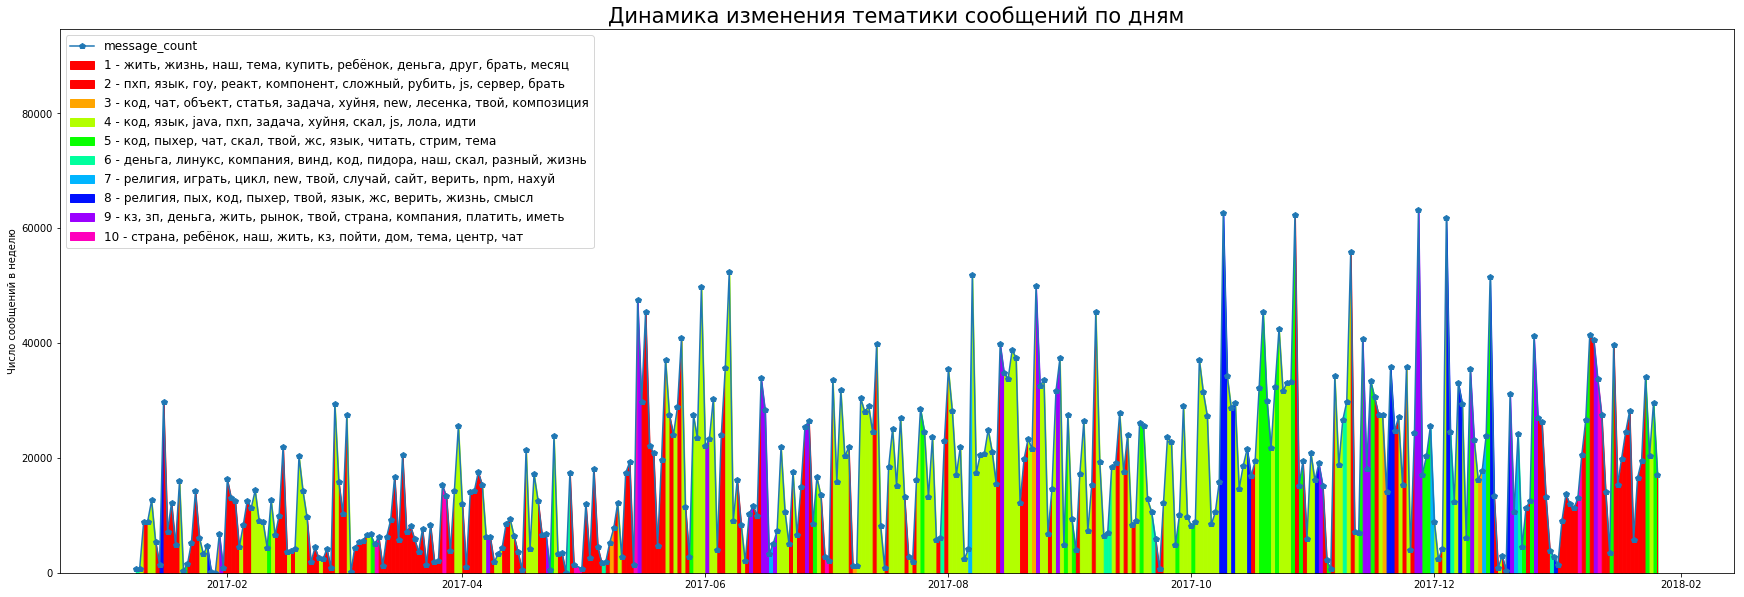

In [79]:
import matplotlib as mpl
cmap = mpl.cm.hsv
normalize = mpl.colors.Normalize(vmin=1, vmax=10)

plt.figure(figsize=(30,10))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(10):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_day_norm.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )
    
plt.legend(fontsize=12)
plt.ylim([0, topic_dynamic.message_count.max() * 1.5])
plt.ylabel('Число сообщений в неделю')
plt.title('Динамика изменения тематики сообщений по дням', fontsize=21)
plt.savefig('devkz_day_dynamic_norm.png')
plt.show()

### Модель построже

In [80]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(day_text_norm, min_df=0.01, max_df=0.45)

Слов в словаре: 16456

Слова до пороговой фильтрации:  [('такой', 5956), ('писать', 3954), ('вообще', 3867), ('человек', 3866), ('весь', 3485), ('год', 3411), ('работать', 3409), ('быть', 3389), ('один', 3345), ('делать', 3345), ('свой', 3202), ('мочь', 3191), ('думать', 2953), ('хотеть', 2866), ('который', 2717), ('самый', 2687), ('норма', 2577), ('какой', 2513), ('говорить', 2488), ('знать', 2481)] 

Слова у верхней границы: ['пыхер', 'тест', 'рубить', 'рынок', 'жаба', 'go', 'пых', 'русский', 'пидора', 'сервис', 'нихуй', 'либ', 'жена', 'книга', 'знание', 'питон', 'логика', 'веб', 'запрос', 'офис', 'база', 'тенг', 'жава', 'религия', 'jvm', 'гугл', 'мак', 'метод', 'стартап', 'похуй', 'машина', 'бот', 'джава', 'класс', 'продукт', 'функция', 'изя', 'фронт', 'умный', 'девушка']

Слова у нижней границы:  ['natural', 'мелкомягкий', 'разность', 'мел', 'разноцветный', 'разоблачение', 'мексиканец', 'разориться', 'ведать', 'разочаровываться', 'разруха', 'разрушение', 'межнациональный', 'racket'

In [81]:
lda_day_norm, gamma_day_norm = get_lda_model(counts, corpus_id2word)

ELBO = -4161080.9605, time: 197 seconds


In [82]:
build_topic_words_report(lda_day_norm, top_words_num=15)

0 topic: пыхер, рубить, пых, пидора, жаба, питон, айфон, go, тупой, телефон, мак, либ, jvm, память, рубистый
1 topic: либ, тест, толеген, сервис, jvm, веб, пыхер, жава, бд, бот, нихуй, питон, go, запрос, семья
2 topic: тест, бд, линукс, внешний, курьер, массив, апи, кейс, лямбда, сервис, исходник, логика, метод, винд, спринг
3 topic: жава, жаба, си, пых, браузер, ида, рынок, память, плюс, пыхер, джава, жрать, jvm, стрим, ниша
4 topic: ноут, мак, dell, покупать, бакс, ssd, xps, ide, go, макбук, idea, плагин, топовый, thinkpad, алмат
5 topic: фп, объект, функция, пыхер, метод, ооп, пых, жаба, сервис, гоу, монада, тест, класс, строка, логика
6 topic: vue, go, стрим, react, jvm, либ, питон, знание, тест, фронт, нода, джава, spring, стартап, база
7 topic: русский, рынок, налог, тенг, жена, рашка, офис, дорогой, алматы, еда, контора, пройти, казах, девушка, рубить
8 topic: пыхер, фронт, книга, докер, жаба, либ, монада, тест, стрим, пых, джава, фронтенд, логика, срач, контейнер
9 topic: религ

In [83]:
topic_dynamic = pd.DataFrame(day_text_norm)
topic_dynamic['topic'] = np.argmax(gamma_day_norm, axis=1)
topic_dynamic['message_count'] = day_text.apply(len)
topic_dynamic['date'] = topic_dynamic.index
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2017-01-09,один нах вёлка печенек раздавать шаломушка сал...,3,598,2017-01-09
2017-01-10,cs год годный интересно сообща учиться мотив д...,8,697,2017-01-10
2017-01-11,здравствовать сергей привет асет килограмм kg ...,4,8769,2017-01-11
2017-01-12,вёлка столько ум один место нужный русло знако...,6,8895,2017-01-12
2017-01-13,welcome плюс писать человек сегодня дело обсто...,0,12624,2017-01-13


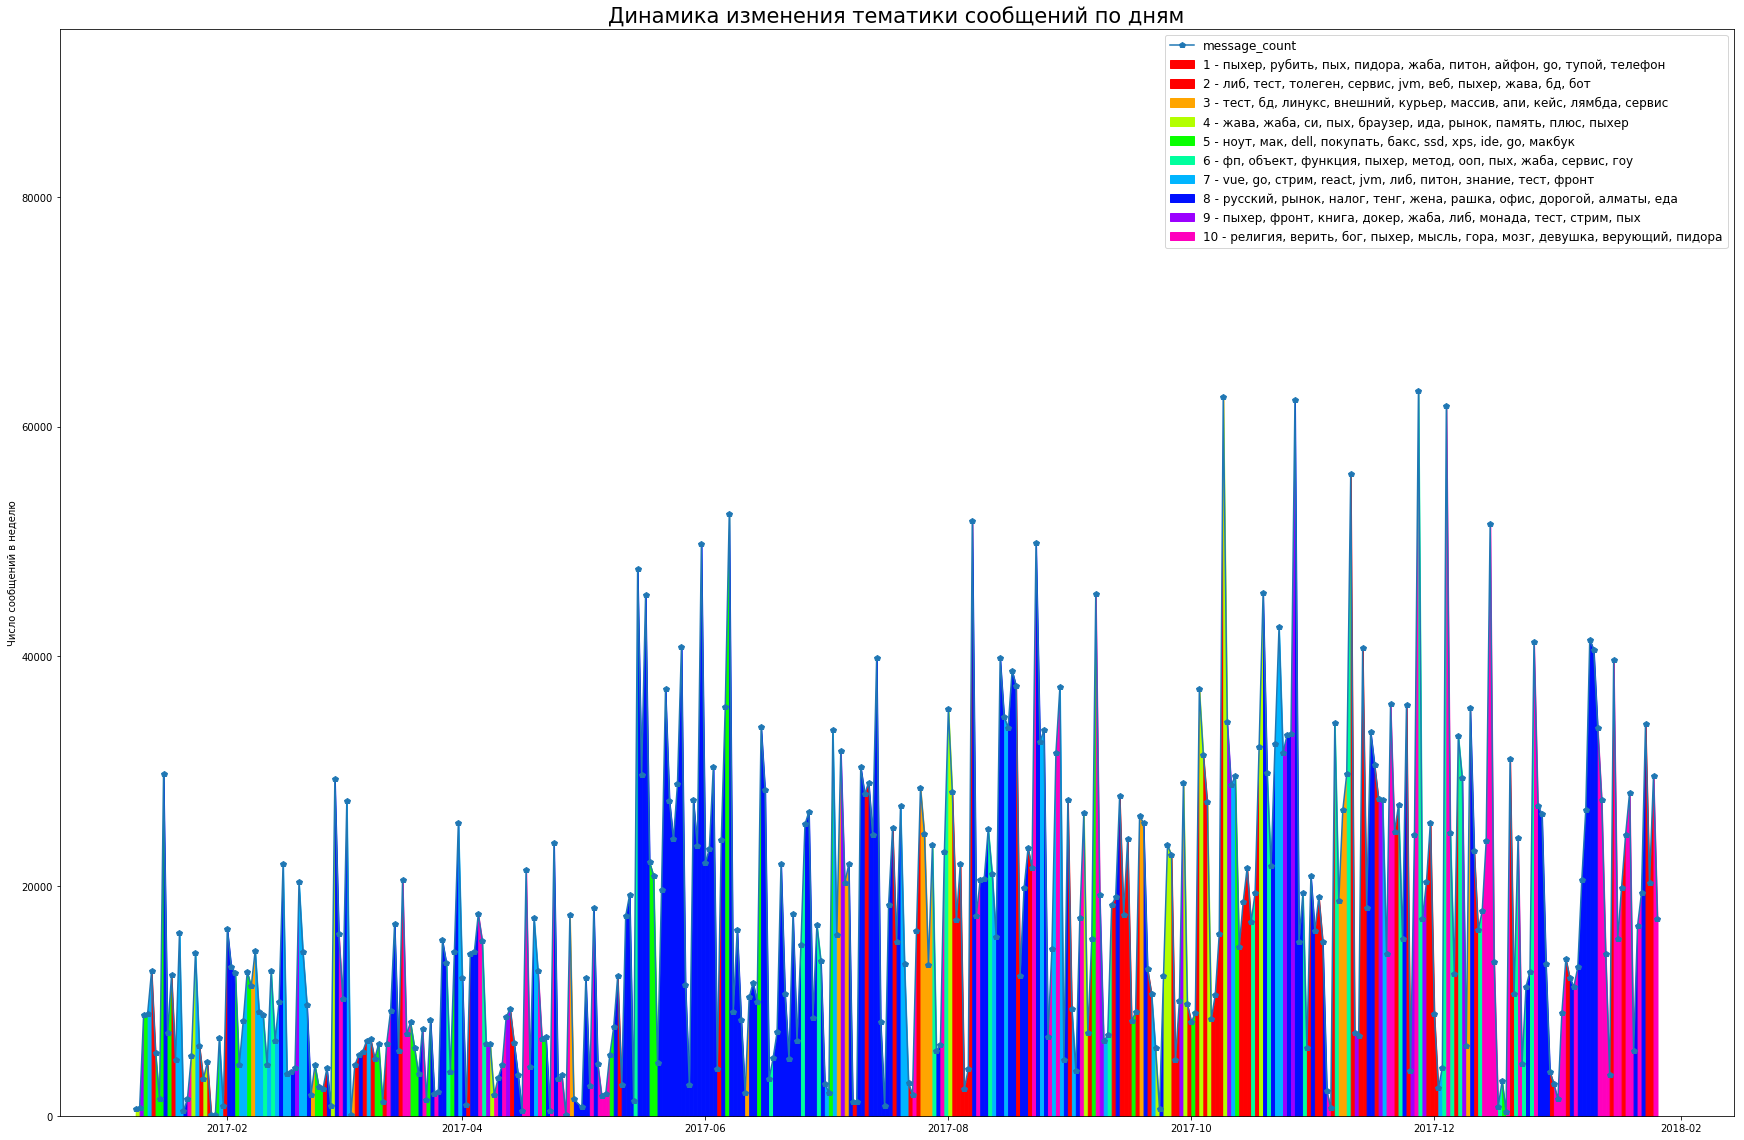

In [85]:
import matplotlib as mpl
cmap = mpl.cm.hsv
normalize = mpl.colors.Normalize(vmin=1, vmax=10)

plt.figure(figsize=(30,20))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(10):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_day_norm.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )
    
plt.legend(fontsize=12)
plt.ylim([0, topic_dynamic.message_count.max() * 1.5])
plt.ylabel('Число сообщений в неделю')
plt.title('Динамика изменения тематики сообщений по дням', fontsize=21)
plt.savefig('devkz_day_dynamic_norm_2.png')
plt.show()

In [86]:
week_text = corpus.groupby(corpus.mes_date.apply(lambda x: '{1}-{0}'.format(x.week, x.year))).agg(lambda x: ' '.join(x))['text']
print(week_text.shape)
week_text.head()

(55,)


mes_date
2017-10    живёшь угу наш мордор названием казахстан  обс...
2017-11    юзал норм щас просто самый последний использую...
2017-12    решил подучить precalculus khanacademy заходит...
2017-13    частный дом подписка месяц жить квартире адок ...
2017-14    jsщики трепаются товарищи чат наших рубистов в...
Name: text, dtype: object

In [87]:
morph = pymorphy2.MorphAnalyzer()
%time week_text_norm = week_text.apply(lambda x: normalise_string(x))
week_text_norm.head()

CPU times: user 2min 50s, sys: 100 ms, total: 2min 50s
Wall time: 2min 50s


mes_date
2017-10    жить наш мордора название казахстан обсуждение...
2017-11    юзал норма щас самый последний использовать id...
2017-12    решить подучить precalculus khanacademy заходи...
2017-13    частный дом подписка месяц жить квартира адок ...
2017-14    jsщик трепаться товарищ чат наш рубистовый воо...
Name: text, dtype: object

In [90]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(week_text_norm, min_df=0.1, max_df=0.5)

Слов в словаре: 9189

Слова до пороговой фильтрации:  [('такой', 5956), ('писать', 3954), ('вообще', 3867), ('человек', 3866), ('весь', 3485), ('год', 3411), ('работать', 3409), ('быть', 3389), ('делать', 3345), ('один', 3345), ('свой', 3202), ('мочь', 3191), ('думать', 2953), ('хотеть', 2866), ('который', 2717), ('самый', 2687), ('норма', 2577), ('какой', 2513), ('говорить', 2488), ('знать', 2481)] 

Слова у верхней границы: ['толика', 'биток', 'элемент', 'кложа', 'ида', 'магнит', 'олжас', 'саня', 'верующий', 'xml', 'редактор', 'раста', 'лямбда', 'суд', 'кормушка', 'ресть', 'учёный', 'типизация', 'сессия', 'скриптовый', 'проц', 'user', 'вера', 'тз', 'жама', 'краснодар', 'руководитель', 'павлодар', 'nginx', 'курьер', 'мс', 'трап', 'постгрес', 'тянка', 'токен', 'религиозный', 'латиница', 'бакенд', 'каспи', 'сериал']

Слова у нижней границы:  ['доделывать', 'апать', 'связывать', 'мнить', 'тренажёрка', 'перебивать', 'священник', 'волшебный', 'fat', 'faster', 'прогаесть', 'кардинально', 'а

In [91]:
lda_week_norm, gamma_week_norm = get_lda_model(counts, corpus_id2word)

ELBO = -1603179.9639, time: 77 seconds


In [92]:
build_topic_words_report(lda_week_norm, top_words_num=15)

0 topic: толика, ида, элемент, кормушка, редактор, типизация, сишник, олжас, ресть, жвм, латиница, тз, саня, xml, руководитель
1 topic: биток, скриптовый, жама, петух, вуз, гепатит, краснодар, золото, дёргать, чурка, gil, берлин, помидор, биржа, екб
2 topic: верующий, вера, библия, церковь, композиция, небо, сознание, атеист, свинья, запрет, свинина, обезьяна, учёный, круда, убийство
3 topic: манга, кыргыз, навязывать, лямбда, трасса, dh, джинерик, киргиз, нг, многопоточность, регулярка, шея, xamarin, ктулха, петух
4 topic: кложа, рекурсия, многопоточность, профессионал, мутабельный, биток, скобка, выгода, подарить, жвм, таир, left, right, розетка, наушник
5 topic: токен, трап, тянка, жама, киргиз, сессия, проц, подруга, var, thinkpad, dell, гей, мусульманин, девка, муж
6 topic: мс, верующий, вера, свинья, атеист, учёный, эволюция, религиозный, 80к, толика, xml, каспи, кресло, кококо, запрет
7 topic: курьер, убер, ачивка, кложа, вич, навальный, магнит, сокет, кук, екб, пицца, fpm, такс

In [93]:
def weekpair_2date(pair):
    atime = time.strptime('{} {} 1'.format(*pair.split('-')), '%Y %W %w')
    return pd.to_datetime('{0}-{1}-{2}'.format(atime.tm_year, atime.tm_mon, atime.tm_mday))

topic_dynamic = pd.DataFrame(week_text_norm)
topic_dynamic['topic'] = np.argmax(gamma_week_norm, axis=1)
topic_dynamic['message_count'] = week_text.apply(len)
topic_dynamic['date'] = list(map(weekpair_2date, topic_dynamic.index))
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2017-2,один нах вёлка печенек раздавать шаломушка сал...,0,38477,2017-01-09
2017-3,наслаждаться кодинг эгоист опенсурс контрибути...,0,71796,2017-01-16
2017-4,универ сайт заблокировать freegate парень tor ...,3,33504,2017-01-23
2017-5,дизайнер который искать работа backend програм...,9,61932,2017-01-30
2017-6,раскладка дворак юзаета пробовать лично qwerty...,0,72985,2017-02-06


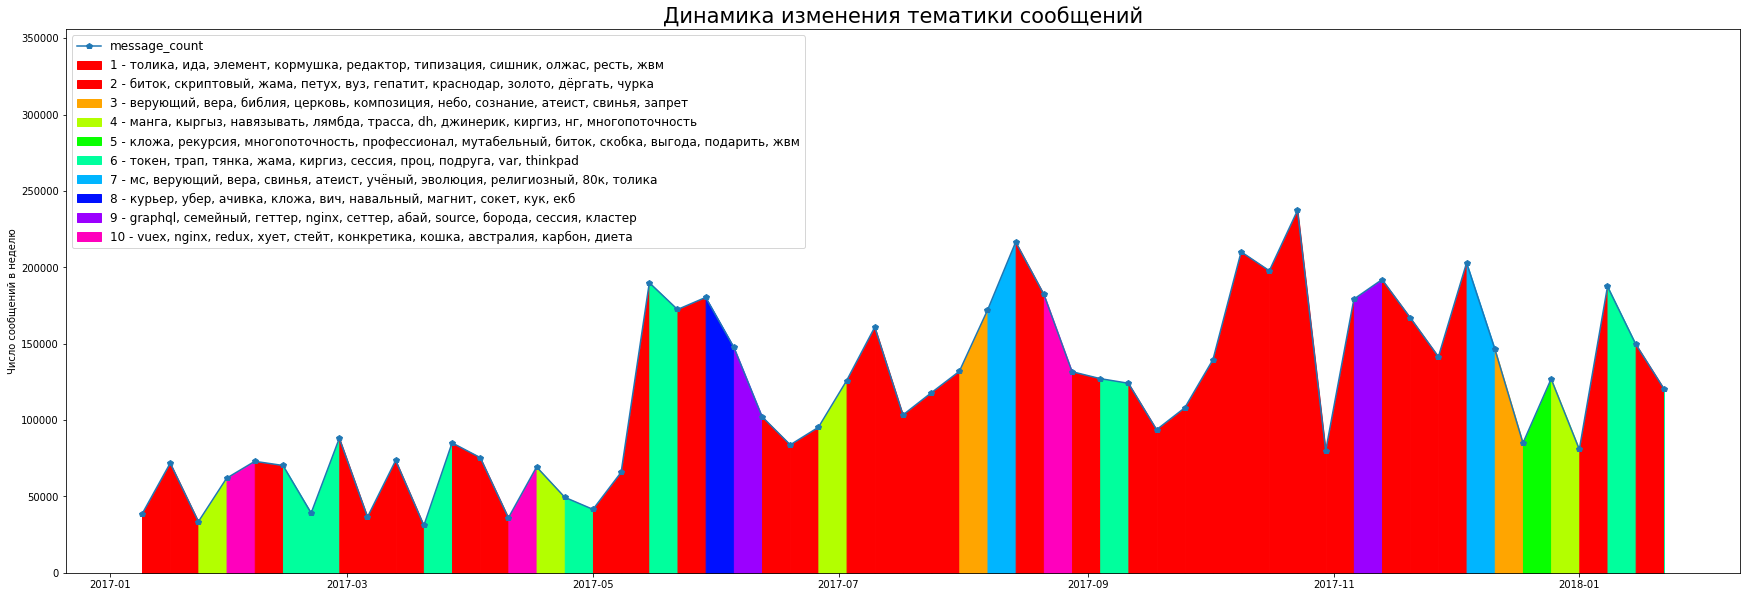

In [100]:
import matplotlib as mpl
cmap = mpl.cm.hsv
normalize = mpl.colors.Normalize(vmin=1, vmax=10)

plt.figure(figsize=(30,10))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(10):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_week_norm.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )
    
plt.legend(fontsize=12)
plt.ylim([0, topic_dynamic.message_count.max() * 1.5])
plt.ylabel('Число сообщений в неделю')
plt.title('Динамика изменения тематики сообщений', fontsize=21)
plt.savefig('devkz_week.png')
plt.show()

In [104]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(week_text_norm, min_df=0.1, max_df=0.75)

Слов в словаре: 10473

Слова до пороговой фильтрации:  [('такой', 5956), ('писать', 3954), ('вообще', 3867), ('человек', 3866), ('весь', 3485), ('год', 3411), ('работать', 3409), ('быть', 3389), ('делать', 3345), ('один', 3345), ('свой', 3202), ('мочь', 3191), ('думать', 2953), ('хотеть', 2866), ('который', 2717), ('самый', 2687), ('норма', 2577), ('какой', 2513), ('говорить', 2488), ('знать', 2481)] 

Слова у верхней границы: ['пыхер', 'жаба', 'пых', 'жава', 'религия', 'толеген', 'стрим', 'срач', 'дебич', 'докер', 'vue', 'толика', 'галера', 'казах', 'монада', 'яндекс', 'ide', 'айфон', 'си', 'банк', 'айрат', 'блокчейн', 'пздца', 'спринг', 'апи', 'дичь', 'вода', 'ruby', 'врач', 'польша', 'фотка', 'жавист', 'образование', 'пхпшник', 'понимание', 'нативный', 'бэк', 'поток', 'поменять', 'контейнер']

Слова у нижней границы:  ['долететь', 'порошок', 'портрет', 'закапывать', 'постройка', 'format', 'foreach', 'посуда', 'потащить', 'потроллировать', 'пофрирайдить', 'поч', 'почекать', 'загуглит

In [105]:
lda_week_norm, gamma_week_norm = get_lda_model(counts, corpus_id2word)

ELBO = -2571910.7140, time: 89 seconds


In [106]:
build_topic_words_report(lda_week_norm, top_words_num=15)

0 topic: пыхер, пых, жаба, стрим, жама, галера, айрат, бутылка, толика, поток, мамка, жсера, бомж, кыргыз, элемент
1 topic: китайский, dell, xps, макбук, монитор, thinkpad, гражданство, ssd, бренд, мент, рам, вёрстка, core, ide, script
2 topic: зуб, айрат, рельс, казах, интел, проц, пыхер, гея, тянка, amd, убунт, шарп, трап, сессия, пошлый
3 topic: религия, пыхер, срач, пых, жаба, толика, верующий, монада, стрим, вера, мышление, наука, религиозный, учёный, пароль
4 topic: пых, си, жаба, пыхер, ида, стрим, жава, срач, ide, сишник, виноватый, докер, редактор, жвм, блокчейн
5 topic: толеген, жава, жаба, пыхер, стрим, апи, пхпшник, докер, спринг, дебич, айфон, дичь, абстракция, пых, ide
6 topic: vue, vscode, spring, ide, node, frontend, idea, кипр, rust, backend, dhl, xml, webpack, шаред, удалёнка
7 topic: vue, контент, компонент, redux, отпуск, китай, шоссера, канада, xamarin, id, яндекс, нативный, кормушка, dh, mysql
8 topic: пыхер, биток, мс, блокчейн, пых, галера, vue, оракл, кровь, то

In [107]:
def weekpair_2date(pair):
    atime = time.strptime('{} {} 1'.format(*pair.split('-')), '%Y %W %w')
    return pd.to_datetime('{0}-{1}-{2}'.format(atime.tm_year, atime.tm_mon, atime.tm_mday))

topic_dynamic = pd.DataFrame(week_text_norm)
topic_dynamic['topic'] = np.argmax(gamma_week_norm, axis=1)
topic_dynamic['message_count'] = week_text.apply(len)
topic_dynamic['date'] = list(map(weekpair_2date, topic_dynamic.index))
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2017-2,один нах вёлка печенек раздавать шаломушка сал...,5,38477,2017-01-09
2017-3,наслаждаться кодинг эгоист опенсурс контрибути...,1,71796,2017-01-16
2017-4,универ сайт заблокировать freegate парень tor ...,7,33504,2017-01-23
2017-5,дизайнер который искать работа backend програм...,7,61932,2017-01-30
2017-6,раскладка дворак юзаета пробовать лично qwerty...,6,72985,2017-02-06


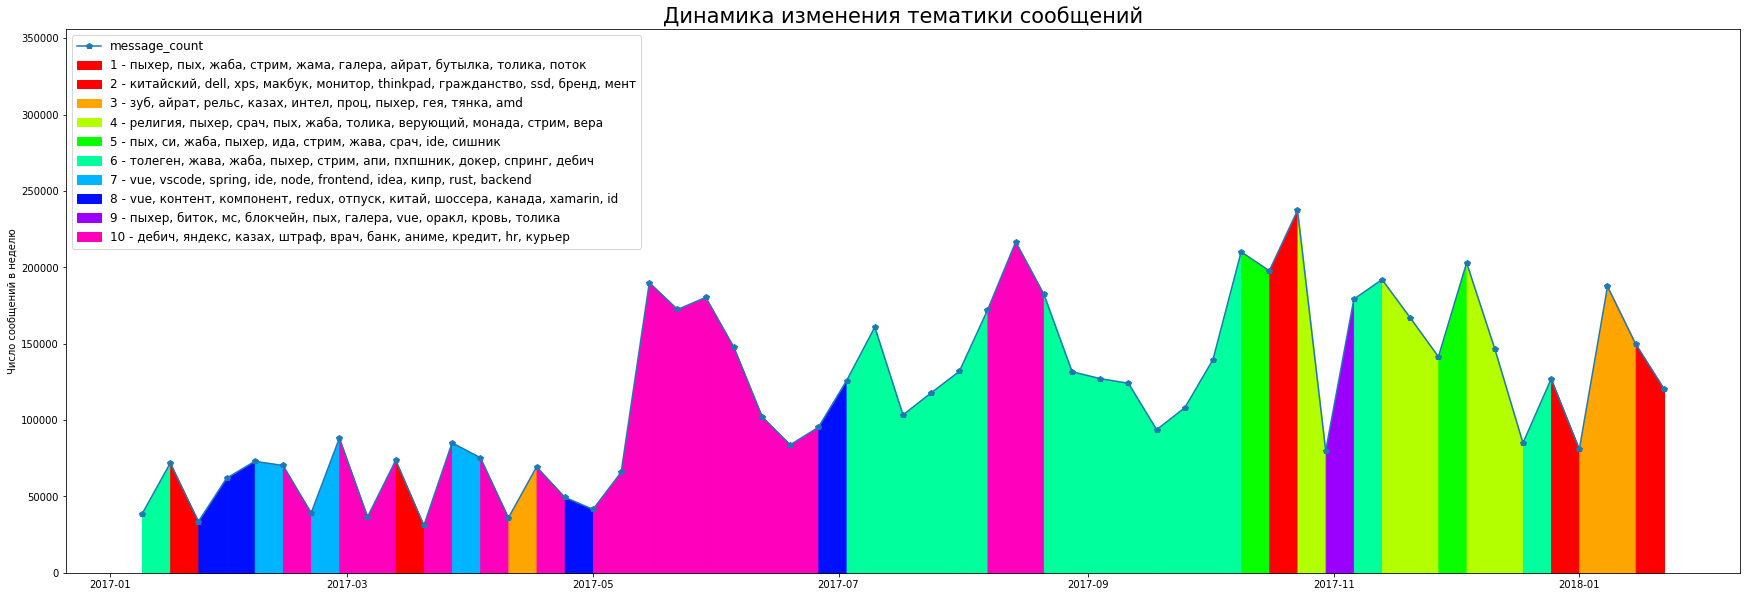

In [108]:
import matplotlib as mpl
cmap = mpl.cm.hsv
normalize = mpl.colors.Normalize(vmin=1, vmax=10)

plt.figure(figsize=(30,10))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(10):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_week_norm.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )
    
plt.legend(fontsize=12)
plt.ylim([0, topic_dynamic.message_count.max() * 1.5])
plt.ylabel('Число сообщений в неделю')
plt.title('Динамика изменения тематики сообщений', fontsize=21)
plt.savefig('devkz_week_2.png')
plt.show()